In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/ml_hw6

/content/gdrive/My Drive/ml_hw6


In [ ]:
! git clone https://github.com/cvlab-stonybrook/LearningToCountEverything.git

fatal: destination path 'LearningToCountEverything' already exists and is not an empty directory.


In [2]:
! git init


Initialized empty Git repository in /content/.git/


In [ ]:
!unzip images_384_VarV2

Archive:  images_384_VarV2.zip
  inflating: images_384_VarV2/1050.jpg  
  inflating: images_384_VarV2/1053.jpg  
  inflating: images_384_VarV2/1061.jpg  
  inflating: images_384_VarV2/1106.jpg  
  inflating: images_384_VarV2/1123.jpg  
  inflating: images_384_VarV2/1130.jpg  
  inflating: images_384_VarV2/1386.jpg  
  inflating: images_384_VarV2/1391.jpg  
  inflating: images_384_VarV2/1397.jpg  
  inflating: images_384_VarV2/1455.jpg  
  inflating: images_384_VarV2/1456.jpg  
  inflating: images_384_VarV2/1458.jpg  
  inflating: images_384_VarV2/1461.jpg  
  inflating: images_384_VarV2/1462.jpg  
  inflating: images_384_VarV2/1463.jpg  
  inflating: images_384_VarV2/1464.jpg  
  inflating: images_384_VarV2/1467.jpg  
  inflating: images_384_VarV2/1493.jpg  
  inflating: images_384_VarV2/1497.jpg  
  inflating: images_384_VarV2/1509.jpg  
  inflating: images_384_VarV2/1537.jpg  
  inflating: images_384_VarV2/1572.jpg  
  inflating: images_384_VarV2/1873.jpg  
  inflating: images_384_Va

In [3]:
%cd /content/gdrive/My Drive/ml_hw6/LearningToCountEverything

/content/gdrive/My Drive/ml_hw6/LearningToCountEverything


In [ ]:
!unzip mask_images

Streaming output truncated to the last 5000 lines.
  inflating: mask_images/2029_anno.png  
  inflating: mask_images/595_anno.png  
  inflating: mask_images/5667_anno.png  
  inflating: mask_images/3674_anno.png  
  inflating: mask_images/587_anno.png  
  inflating: mask_images/49_anno.png  
  inflating: mask_images/2894_anno.png  
  inflating: mask_images/5033_anno.png  
  inflating: mask_images/7698_anno.png  
  inflating: mask_images/345_anno.png  
  inflating: mask_images/5921_anno.png  
  inflating: mask_images/3883_anno.png  
  inflating: mask_images/4469_anno.png  
  inflating: mask_images/5082_anno.png  
  inflating: mask_images/6902_anno.png  
  inflating: mask_images/6400_anno.png  
  inflating: mask_images/5257_anno.png  
  inflating: mask_images/3247_anno.png  
  inflating: mask_images/4038_anno.png  
  inflating: mask_images/200_anno.png  
  inflating: mask_images/7547_anno.png  
  inflating: mask_images/2272_anno.png  
  inflating: mask_images/5936_anno.png  
  inflating:

In [ ]:
!python3 "test.py" --data_path data/ --test_split val

Evaluation on val data
  0% 0/1286 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
190.jpg : actual-predicted:     13,   60.9, error:   47.9. Current MAE: 47.91, RMSE: 47.91:   0% 0/1286 [00:00<?, ?it/s]
191.jpg : actual-predicted:     15,   16.3, error:    1.3. Current MAE: 24.60, RMSE: 33.89:   0% 1/1286 [00:00<03:24,  6.28it/s]
192.jpg : actual-predicted:     19,   16.9, error:    2.1. Current MAE: 17.09, RMSE: 27.70:   0% 1/1286 [00:00<03:24,  6.28it/s]
194.jpg : actual-predicted:     82,   63.6, error:   18.4. Current MAE: 17.41, RMSE: 25.68:   0% 3/1286 [00:00<02:52,  7.45it/s]
195.jpg : actual-predicted:     10,    9.9, error:    0.1. Current MAE: 13.94, RMSE

In [ ]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim

data_path = "data/"
test_split = "val"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = False
gradient_steps = 100
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-4


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

im_id2 = []
gt_l = []
pred_l = []
out = []

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)



            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)
    im_id2.append(im_id)
    out.append(output)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2


high_oc = np.array(pred_l) - np.array(gt_l)
high_oc = np.argsort(high_oc)[-5:]

high_uc = np.array(gt_l) - np.array(pred_l)
high_uc = np.argsort(high_uc)[-5:]



  0%|          | 0/1286 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 1/1286 [00:00<03:19,  6.43it/s]

Evaluation on val data


100%|██████████| 1286/1286 [01:27<00:00, 14.77it/s]


[60.907745361328125, 16.291074752807617, 16.92751693725586, 63.642303466796875, 9.924295425415039, 61.27728271484375, 81.02568054199219, 61.1616325378418, 36.648799896240234, 96.38662719726562, 27.589984893798828, 72.2542953491211, 50.70586013793945, 50.34369659423828, 41.16633224487305, 23.79133415222168, 70.08517456054688, 16.00101089477539, 66.87071990966797, 69.66957092285156, 21.79428482055664, 47.625877380371094, 30.34103775024414, 47.71561050415039, 107.17872619628906, 40.76728057861328, 33.71512985229492, 75.41116333007812, 15.453472137451172, 24.55307960510254, 26.92384910583496, 36.82303237915039, 71.31874084472656, 48.43233871459961, 58.64387893676758, 21.42306900024414, 22.86761474609375, 28.976985931396484, 27.546308517456055, 66.45320892333984, 29.990150451660156, 170.2755889892578, 54.14080810546875, 42.31401443481445, 40.897544860839844, 132.4605712890625, 11.464388847351074, 21.741369247436523, 18.437362670898438, 30.487262725830078, 33.86350631713867, 27.9626617431640

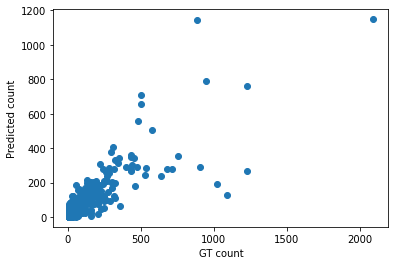

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(np.array(gt_l),np.array(pred_l))
plt.xlabel('GT count')
plt.ylabel('Predicted count')
plt.show()

In [ ]:
print (high_oc)

[ 347 1186  448  299  437]


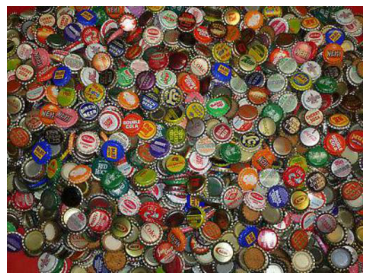

In [ ]:
fig = plt.figure( )
image = Image.open('{}/{}'.format(im_dir, im_id2[347]))
image.load()
plt.imshow(image)
plt.axis('off')
plt.tight_layout()

1
2
3
4
5


<function matplotlib.pyplot.show>

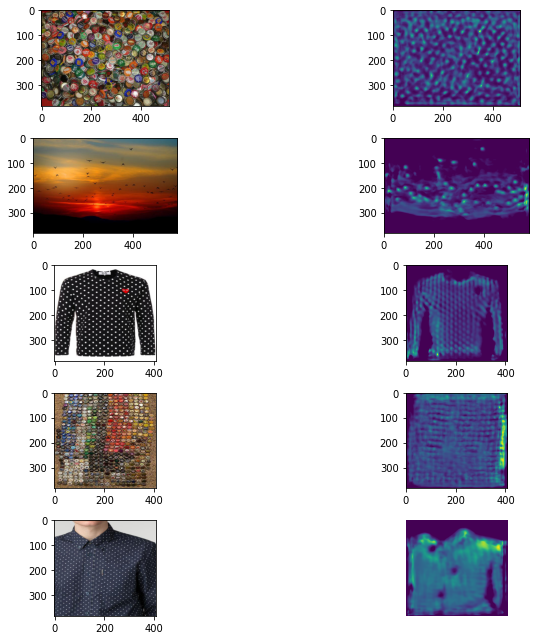

In [ ]:
fig = plt.figure(figsize=(12,9))
count = 0
for i in range (0,10,2) :
  plt.subplot(5,2, i+1)
  image = Image.open('{}/{}'.format(im_dir, im_id2[high_oc[count]]))
  image.load()
  plt.imshow(image)

  plt.subplot(5,2, i+2)
  plt.imshow(out[high_oc[count]][0][0].cpu().numpy())
  count += 1
  print (count)

plt.axis('off')
plt.tight_layout()
plt.show

1
2
3
4
5


<function matplotlib.pyplot.show>

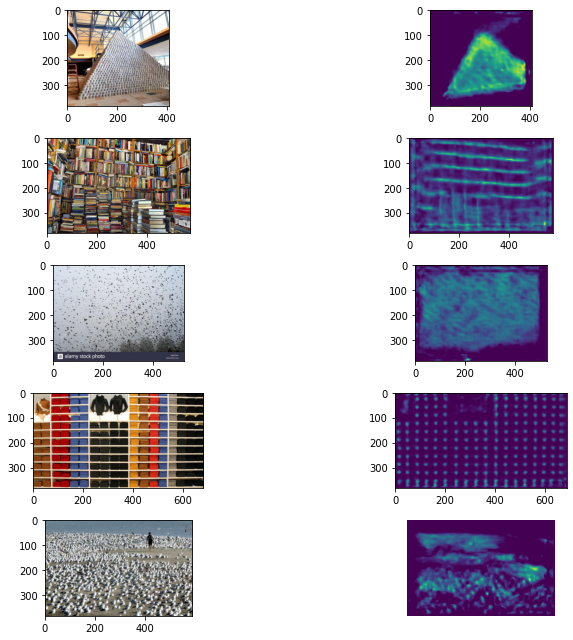

In [ ]:
fig = plt.figure(figsize=(12,9))
count = 0
for i in range (0,10,2) :
  plt.subplot(5,2, i+1)
  image = Image.open('{}/{}'.format(im_dir, im_id2[high_uc[count]]))
  image.load()
  plt.imshow(image)

  plt.subplot(5,2, i+2)
  plt.imshow(out[high_uc[count]][0][0].cpu().numpy())
  count += 1
  print (count)

plt.axis('off')
plt.tight_layout()
plt.show

In [4]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim
from torchvision.transforms import ToTensor

data_path = "data/"
test_split = "val"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = False
gradient_steps = 100
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-4


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

im_id2 = []
gt_l = []
pred_l = []
out = []

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

#print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids, position = 0, leave = True)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    image2 = Image.open('{}/{}'.format(im_dir2, im_id.split(".")[0] + "_anno.png"))
    image2.load()
    image2 = ToTensor()(image2)  #unsqueeze(0)

    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)

            lmask = weight_maskloss * torch.sum(output + image2)

            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation + lmask
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)
    im_id2.append(im_id)
    out.append(output)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2

     #pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}'.\
                         #format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5))
     #print("")

print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))




Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0/1286 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 1286/1286 [10:36<00:00,  2.02it/s]

On val data, MAE:  24.32, RMSE:  70.94


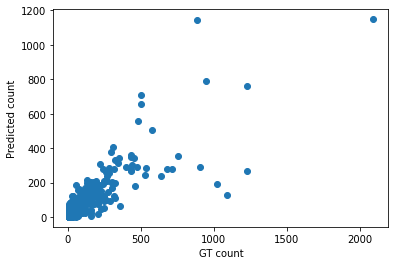

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(np.array(gt_l),np.array(pred_l))
plt.xlabel('GT count')
plt.ylabel('Predicted count')
plt.show()

In [ ]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim
from torchvision.transforms import ToTensor,Resize

data_path = "data/"
test_split = "val_PartA"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = True
gradient_steps = 30
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-4

gt_l = []
pred_l = []


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

#print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids, position = 0, leave = True)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    image2 = Image.open('{}/{}'.format(im_dir2, im_id.split(".")[0] + "_anno.png"))
    image2.load()
    image2 = ToTensor()(image2)[0,:,:]
    image2 = image2.unsqueeze(0).unsqueeze(0)

    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()
        image2 = image2.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)


            image2 = Resize((output.shape[2],output.shape[3]))(image2)
            #image2 = image2.resize(1,1,output.shape[2],output.shape[3])

            if output.shape != image2.shape :
              print (output.shape, image2.shape)

            lmask = weight_maskloss * torch.sum(output + image2)

            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation + lmask
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2

     #pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}'.\
                         #format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5))
     #print("")

print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))




  0%|          | 0/1286 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 1/1286 [00:00<12:12,  1.75it/s]/content/gdrive/My Drive/ml_hw6/LearningToCountEverything/utils.py:99: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss += F.mse_loss(X,ones)
100%|██████████| 1286/1286 [09:56<00:00,  2.16it/s]

On val data, MAE:  24.32, RMSE:  71.16


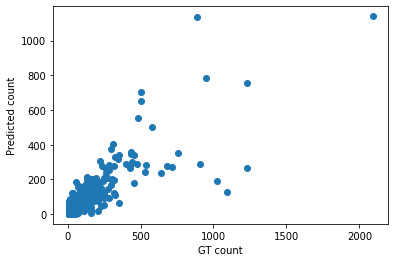

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(np.array(gt_l),np.array(pred_l))
plt.xlabel('GT count')
plt.ylabel('Predicted count')
plt.show()

In [11]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim
from torchvision.transforms import ToTensor,Resize

data_path = "data/"
test_split = "test_PartA"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = True
gradient_steps = 30
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-4

gt_l = []
pred_l = []
im_id2 = []


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

#print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids, position = 0, leave = True)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    image2 = Image.open('{}/{}'.format(im_dir2, im_id.split(".")[0] + "_anno.png"))
    image2.load()
    image2 = ToTensor()(image2)[0,:,:]
    image2 = image2.unsqueeze(0).unsqueeze(0)

    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()
        image2 = image2.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)


            image2 = Resize((output.shape[2],output.shape[3]))(image2)
            #image2 = image2.resize(1,1,output.shape[2],output.shape[3])

            if output.shape != image2.shape :
              print (output.shape, image2.shape)

            lmask = weight_maskloss * torch.sum(output + image2)

            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation + lmask
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)
    im_id2.append(im_id)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2

     #pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}'.\
                         #format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5))
     #print("")

print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))




  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/content/gdrive/My Drive/ml_hw6/LearningToCountEverything/utils.py:99: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss += F.mse_loss(X,ones)
100%|██████████| 100/100 [04:01<00:00,  2.42s/it]

On test_PartA data, MAE:  45.02, RMSE:  64.27


In [6]:
import pandas as pd

pred_l = [round (x) for x in pred_l]

d = {'ID':im_id2,'Count':pred_l}
Data = pd.DataFrame(d)

print (Data)
Data.to_csv('out2.csv', index = False, header = True)

            ID  Count
0        2.jpg     11
1        3.jpg     24
2        4.jpg     34
3        5.jpg    106
4        6.jpg     35
...        ...    ...
1185  6918.jpg     74
1186  7500.jpg     79
1187  7047.jpg     90
1188  7412.jpg     19
1189  6901.jpg     39

[1190 rows x 2 columns]


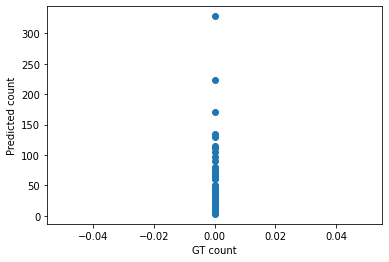

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(np.array(gt_l),np.array(pred_l))
plt.xlabel('GT count')
plt.ylabel('Predicted count')
plt.show()

In [ ]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim
from torchvision.transforms import ToTensor,Resize

data_path = "data/"
test_split = "val_PartA"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = True
gradient_steps = 30
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-4

gt_l = []
pred_l = []


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

#print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids, position = 0, leave = True)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    image2 = Image.open('{}/{}'.format(im_dir2, im_id.split(".")[0] + "_anno.png"))
    image2.load()
    image2 = ToTensor()(image2)[0,:,:]
    image2 = image2.unsqueeze(0).unsqueeze(0)

    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()
        image2 = image2.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)


            image2 = Resize((output.shape[2],output.shape[3]))(image2)
            #image2 = image2.resize(1,1,output.shape[2],output.shape[3])

            if output.shape != image2.shape :
              print (output.shape, image2.shape)

            lmask = weight_maskloss * torch.sum(output + image2)

            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation + lmask
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2

     #pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}'.\
                         #format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5))
     #print("")

print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))




  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/content/gdrive/My Drive/ml_hw6/LearningToCountEverything/utils.py:99: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss += F.mse_loss(X,ones)
100%|██████████| 100/100 [04:06<00:00,  2.47s/it]

On val_PartA data, MAE:  15.82, RMSE:  26.03


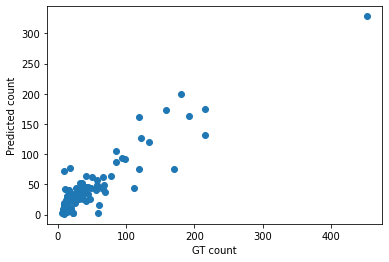

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.scatter(np.array(gt_l),np.array(pred_l))
plt.xlabel('GT count')
plt.ylabel('Predicted count')
plt.show()

In [10]:
import copy
from model import CountRegressor, Resnet50FPN
from utils import MAPS, Scales, Transform, extract_features
from utils import MincountLoss, PerturbationLoss
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import torch.optim as optim
from torchvision.transforms import ToTensor,Resize

data_path = "data/"
test_split = "test"
model_path = 'data/pretrainedModels/FamNet_Save1.pth'
gpu_id = 0
adapt = True
gradient_steps = 10
learning_rate = 1e-7
weight_mincount = 1e-9
weight_perturbation = 1e-4
weight_maskloss = 1e-9

gt_l = []
pred_l = []
im_id2 = []


'''

parser = argparse.ArgumentParser(description="Few Shot Counting Evaluation code")
parser.add_argument("-dp", "--data_path", type=str, default='data/', help="Path to the FSC147 dataset")
parser.add_argument("-ts", "--test_split", type=str, default='val', choices=["val_PartA","val_PartB","test_PartA","test_PartB","test", "val"], help="what data split to evaluate on")
parser.add_argument("-m",  "--model_path", type=str, default="data/pretrainedModels/FamNet_Save1.pth", help="path to trained model")
parser.add_argument("-a",  "--adapt", action='store_true', help="If specified, perform test time adaptation")
parser.add_argument("-gs", "--gradient_steps", type=int,default=100, help="number of gradient steps for the adaptation")
parser.add_argument("-lr", "--learning_rate", type=float,default=1e-7, help="learning rate for adaptation")
parser.add_argument("-wm", "--weight_mincount", type=float,default=1e-9, help="weight multiplier for Mincount Loss")
parser.add_argument("-wp", "--weight_perturbation", type=float,default=1e-4, help="weight multiplier for Perturbation Loss")
parser.add_argument("-g",  "--gpu-id", type=int, default=0, help="GPU id. Default 0 for the first GPU. Use -1 for CPU.")
'''

anno_file = data_path + 'annotation_Val_Test_384_VarV2.json'
data_split_file = data_path + 'Train_Test_Val_FSC147_HW6_Split.json'
im_dir = data_path + 'images_384_VarV2'
im_dir2 = data_path + 'mask_images'

if not exists(anno_file) or not exists(im_dir) or not exists(im_dir2):
    print("Make sure you set up the --data-path correctly.")
    print("Current setting is {}, but the image dir and annotation file do not exist.".format(data_path))
    print("Aborting the evaluation")
    exit(-1)

if not torch.cuda.is_available() or gpu_id < 0:
    use_gpu = False
    print("===> Using CPU mode.")
else:
    use_gpu = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

resnet50_conv = Resnet50FPN()
if use_gpu: resnet50_conv.cuda()
resnet50_conv.eval()

regressor = CountRegressor(6, pool='mean')
regressor.load_state_dict(torch.load(model_path))
if use_gpu: regressor.cuda()
regressor.eval()

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)

cnt = 0
SAE = 0  # sum of absolute errors
SSE = 0  # sum of square errors

#print("Evaluation on {} data".format(test_split))
im_ids = data_split[test_split]
pbar = tqdm(im_ids, position = 0, leave = True)
for im_id in pbar:
    anno = annotations[im_id]
    bboxes = anno['box_examples_coordinates']
    dots = np.array(anno['points'])

    rects = list()
    for bbox in bboxes:
        x1, y1 = bbox[0][0], bbox[0][1]
        x2, y2 = bbox[2][0], bbox[2][1]
        rects.append([y1, x1, y2, x2])

    image = Image.open('{}/{}'.format(im_dir, im_id))
    image.load()
    image2 = Image.open('{}/{}'.format(im_dir2, im_id.split(".")[0] + "_anno.png"))
    image2.load()
    image2 = ToTensor()(image2)[0,:,:]
    image2 = image2.unsqueeze(0).unsqueeze(0)

    sample = {'image': image, 'lines_boxes': rects}
    sample = Transform(sample)
    image, boxes = sample['image'], sample['boxes']

    if use_gpu:
        image = image.cuda()
        boxes = boxes.cuda()
        image2 = image2.cuda()

    with torch.no_grad(): features = extract_features(resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)

    if not adapt:
        with torch.no_grad(): output = regressor(features)
    else:
        features.required_grad = True
        adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=learning_rate)
        for step in range(0, gradient_steps):
            optimizer.zero_grad()
            output = adapted_regressor(features)


            image2 = Resize((output.shape[2],output.shape[3]))(image2)
            #image2 = image2.resize(1,1,output.shape[2],output.shape[3])

            if output.shape != image2.shape :
              print (output.shape, image2.shape)

            lmask = weight_maskloss * torch.sum(output + image2)

            lCount = weight_mincount * MincountLoss(output, boxes)
            lPerturbation = weight_perturbation * PerturbationLoss(output, boxes, sigma=8)
            Loss = lCount + lPerturbation + lmask
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()
        features.required_grad = False
        output = adapted_regressor(features)

    gt_cnt = dots.shape[0]
    pred_cnt = output.sum().item()

    gt_l.append(gt_cnt)
    pred_l.append(pred_cnt)
    im_id2.append(im_id)

    cnt = cnt + 1
    err = abs(gt_cnt - pred_cnt)
    SAE += err
    SSE += err**2

     #pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}'.\
                         #format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5))
     #print("")

print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))




  0%|          | 0/1190 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 1/1190 [00:01<20:34,  1.04s/it]/content/gdrive/My Drive/ml_hw6/LearningToCountEverything/utils.py:99: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Loss += F.mse_loss(X,ones)
100%|██████████| 1190/1190 [16:42<00:00,  1.19it/s]

On test data, MAE:  61.18, RMSE: 108.29


In [ ]:
import pandas as pd

pred_l = [round (x) for x in pred_l]

d = {'ID':im_id2,'Count':pred_l}
Data = pd.DataFrame(d)

print (Data)
Data.to_csv('out2.csv', index = False, header = True)